In [1]:
!pip install transformers
!pip install tqdm

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 
     |████████████████████████████████| 901kB 46.6MB/s 


# 0. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# torch and transformers
import torch
from torch import cuda
import transformers
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertForSequenceClassification

#import different metrics to evaluate the classifiers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

from tqdm import tqdm

import itertools
import re

# 1. Utils

In [3]:
################################
# text processing and cleaning #
################################

def is_ascii(w):
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

def encode_taxonomy(taxonomy):
  """
  Label encode taxonomy for training distilbert.

  Parameters:
  -----------
  taxonomy: int, taxonomy class
  
  Returns:
  --------
  encoding: int, encoded taxonomy class
  """
  encoding_dict = {2: 0, 9: 1, 59: 2, 70: 3, 173: 4, 268: 5, 273: 6, 280: 7}
  encoding = encoding_dict[taxonomy]

  return encoding


def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text


def text_preprocessing_a1(text):
  """
  Approach 1: Join first 2 sentences with last 2 sentences of the text.
  
  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  preprocessed_text: string, preprocessed text data
  """
  # sentence tokenize based on '. '
  sentences = text.split('. ')
  # get 2 first and 2 last sentences
  if len(sentences) >= 4:
    preprocessed_text = ". ".join(text.split('. ')[:2] + text.split('. ')[-2:])
    return preprocessed_text
  # if there are not 4 sentences, return full text
  else:
    preprocessed_text = text
    return preprocessed_text


def preprocessing_a1(df):
  """
  Cleaning and preprocessing following approach 1.

  Parameters:
  -----------
  df: Pandas DataFrame, df with `title`, `description` and `taxonomy`
  
  Returns:
  --------
  preprocessed_df: Pandas DataFrame, df with `text` (preprocessed text) and `taxonomy`
  """
  # drop rows with missing descriptions and drop title
  cleaned_df = df.dropna(axis=0).drop('title', axis=1)
  # clean description
  cleaned_df['description'] = cleaned_df['description'].map(text_cleaning)
  # preprocess description
  preprocessed_df = cleaned_df.copy()
  preprocessed_df['description'] = cleaned_df['description'].map(text_preprocessing_a1)
  preprocessed_df = preprocessed_df.rename(columns={'description': 'text'})
  # keep examples with less than 210 tokens
  preprocessed_df = preprocessed_df[preprocessed_df['text'].map(lambda x: len(x.split())) < 210]

  # encode taxonomy
  preprocessed_df['taxonomy'] = preprocessed_df['taxonomy'].map(encode_taxonomy)

  return preprocessed_df

##############
# Evaluation #
##############

def plot_learning(train_loss, val_loss, val_acc, EPOCHS):
    """Plot training history.

    Plot 1: Loss / epochs
    Plot 2: Val_Acc / epochs

    Parameters:
    ___________

    train_loss, val_loss, val_acc: Lists
    EPOCHS: int
    ___________

    Returns: None
    """

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 7))
    plt.plot(epochs, train_loss, 'b',c="blue", label='Training loss')
    plt.plot(epochs, val_loss, 'b',c="orange", label='Validation loss')
    plt.xticks(ticks=[epoch for epoch in range(1, EPOCHS+1)])
    plt.title('Training and validation loss')
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.figure(figsize=(14, 7))
    plt.plot(epochs, val_acc, 'b',c="orange", label='Validation acc')
    plt.xticks(ticks=[epoch for epoch in range(1, EPOCHS+1)])
    plt.title('Validation acc')
    plt.xlabel("# Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show();

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Config

In [4]:
TRAIN_FILE = '/content/drive/MyDrive/Colab Notebooks/PFM/data/train_v0.csv'
VAL_FILE = '/content/drive/MyDrive/Colab Notebooks/PFM/data/val_v0.csv'
TEST_FILE = '/content/drive/MyDrive/Colab Notebooks/PFM/data/test_v0.csv'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/PFM/models/taxonomy_approach_1_weighted_CE.bin'

# Defining some key variables that will be used later on in the training
MAX_LEN = 210
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5
SEED = 42

TOKENIZER = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Setting up the device for GPU usage
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)


cuda


# 3. Data

In [5]:
train = pd.read_csv(TRAIN_FILE, index_col=0, encoding='utf-8')
val = pd.read_csv(VAL_FILE, index_col=0, encoding='utf-8')

print(train.shape, val.shape)

(41915, 3) (8982, 3)


In [6]:
train.head(), val.head()

(                                          title  ... taxonomy
 10525                      Bernina Accessoireag  ...      273
 19671  ABC iPad - Like a computer and even more  ...       70
 37172                            Meisterkonzert  ...      173
 43220                                       GZA  ...      173
 6905                            Little BIG City  ...      273
 
 [5 rows x 3 columns],
                                                    title  ... taxonomy
 53537                                       Frieda Braun  ...      268
 56146                           ADVENTURES ON THE ISLAND  ...      280
 5024                                     The Big 5 Qatar  ...       70
 16720  "I never wear skirts because I can not cross m...  ...      268
 53079              Pablo AlborÃ¡n Concert "Tour Prometo"  ...      173
 
 [5 rows x 3 columns])

## 3.1. Class Weights

Define class weights for Cross Entropy Loss to account for class imbalance as the inverse frequency of each category.

In [7]:
encoding_dict = {2: 0, 9: 1, 59: 2, 70: 3, 173: 4, 268: 5, 273: 6, 280: 7}
class_weights = {encoding_dict[i[0]]: i[1] for i in (train['taxonomy'].value_counts().map(lambda x: 1/x)).items()}
class_weights

{0: 0.0002387774594078319,
 1: 0.010526315789473684,
 2: 0.0002701242571582928,
 3: 0.00043554006968641115,
 4: 7.664009809932556e-05,
 5: 0.00015078407720144752,
 6: 0.00012023566189731875,
 7: 0.00027495188342040145}

In [8]:
# class weights tensor
class_weights_tensor = torch.tensor([class_weights[k] for k in sorted(class_weights.keys())], dtype=torch.float).cuda()
WEIGHTS = class_weights_tensor

# 4. Dataset and Dataloader

Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network.


In [9]:
class DistilBertDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.data['text'].loc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data['taxonomy'].loc[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [10]:
# creating the dataset and dataloader for the neural network
# clean and preprocess
preprocessed_train = preprocessing_a1(train).reset_index(drop=True)
preprocessed_val = preprocessing_a1(val).reset_index(drop=True)

print("TRAIN Dataset: {}".format(train.shape))
print("VAL Dataset: {}".format(val.shape))

TRAIN Dataset: (41915, 3)
VAL Dataset: (8982, 3)


In [11]:
training_set = DistilBertDataset(preprocessed_train, TOKENIZER, MAX_LEN)
validation_set = DistilBertDataset(preprocessed_val, TOKENIZER, MAX_LEN)

In [12]:
print("---- Visually inspecting 5th element ----")
print(f"Input ids: {training_set[6]['ids']}")
print(f"Attention masks: {training_set[6]['mask']}")
print(f"Target: {training_set[6]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----
Input ids: tensor([  101,  6688,  3321,  2072,  6765,  2015, 10930,  1010, 22554,  1010,
         2012,  1996, 24048,  4258,  1012,  1996,  2265,  2003,  2141,  1997,
         1996,  4969,  4125,  1997,  1996,  2214, 14870, 13165,  1010,  2029,
         2003,  1037,  3622,  4119,  2000,  2111,  2040,  2031,  2467,  4061,
         2005,  1037,  2062, 16408,  1998, 24464,  2594,  2166,  1012,  3858,
         4969,  2005,  2010, 27856,  8900,  4616,  1998,  2010,  7601, 17897,
        16670, 26422,  4506,  1010,  6688, 17146,  2007,  2023,  2537,  2000,
         9462,  2576, 27505,  2015,  1998,  2265,  1996, 25312, 20142,  3012,
         1997, 14870,  2245,  1012,  2009,  2003,  1037, 26422,  1998,  6057,
         3538,  1010,  2881,  2000,  9699, 27451,  1998,  2507,  1996,  2270,
         2008,  3310,  2041,  1997,  1996,  4258,  4792,  2000,  9507,  2030,
         2488, 15544,  6190,  2102,  2007,  4454,  2000,  2046,  3917,  6651,
         10

In [13]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VAL_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_data_loader = DataLoader(training_set, **train_params)
val_data_loader = DataLoader(validation_set, **val_params)

# 5. Creating the NN for fine tuning

#### Neural Network
 - We will be creating a neural network with the `DistillBERTClass`. 
 - This network will have the DistilBERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
 - The data will be fed to the DistilBERT Language model as defined in the dataset. 
 - Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. 
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [14]:
# Creating the customized model, by adding a drop out and a dense layer on top of distilbert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 8) # 8 unique classes

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

# 6. Train and Evaluation

In [15]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=WEIGHTS)(outputs, targets)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d['ids']
        mask = d['mask']
        targets = d['targets']

        # send them to device
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(input_ids=ids, attention_mask=mask)

        # calculate loss
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
    
    return loss

def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            val_loss = loss_fn(outputs, targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets, val_loss

# 6. Fine Tuning the Model



In [16]:
def fit():
    model = DistillBERTClass()
    param_optimizer = list(model.named_parameters())

    device = DEVICE
    model.to(DEVICE)

    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_parameters, lr=3e-5)

    train_loss = []
    val_loss = []
    val_acc = []
    val_f_scores = []
    best_accuracy = 0
    for i, epoch in enumerate(range(EPOCHS)):
        print(f"Epoch {i + 1}.")
        train_loss_epoch = train_fn(train_data_loader, model, optimizer, device)
        outputs, targets, val_loss_epoch = eval_fn(val_data_loader, model, device)
        train_loss.append(train_loss_epoch)
        val_loss.append(val_loss_epoch)
        outputs = np.argmax(outputs, axis=1)
        accuracy = accuracy_score(targets, outputs)
        f_score = f1_score(targets, outputs, average='weighted')
        val_acc.append(accuracy)
        val_f_scores.append(f_score)
        print(f"Validation Accuracy Score = {accuracy}")
        print(f"Validation F1-Score = {f_score}")
        # save best model
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = accuracy

    return train_loss, val_loss, val_acc

In [ ]:
train_loss, val_loss, val_acc = fit()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 1.


100%|██████████| 440/440 [01:39<00:00,  4.44it/s]


Validation Accuracy Score = 0.7352481160244562
Validation F1-Score = 0.7420802435877232


  0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 2.


100%|██████████| 440/440 [01:39<00:00,  4.44it/s]


Validation Accuracy Score = 0.7594198777193232
Validation F1-Score = 0.7611993900855566


  0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 3.


100%|██████████| 440/440 [01:39<00:00,  4.44it/s]


Validation Accuracy Score = 0.7749182425707379
Validation F1-Score = 0.7767901756634921


  0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 4.


100%|██████████| 440/440 [01:39<00:00,  4.44it/s]


Validation Accuracy Score = 0.7824541447461965
Validation F1-Score = 0.7834823093960294


  0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 5.


100%|██████████| 440/440 [01:39<00:00,  4.44it/s]


Validation Accuracy Score = 0.7851556945826816
Validation F1-Score = 0.7866395637628797


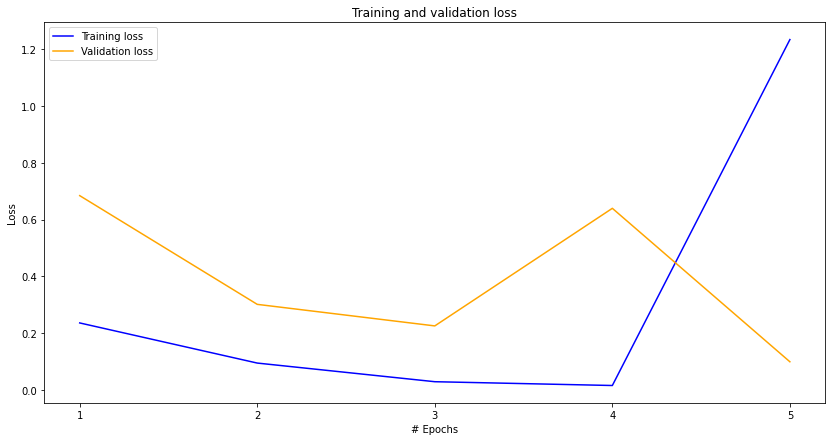

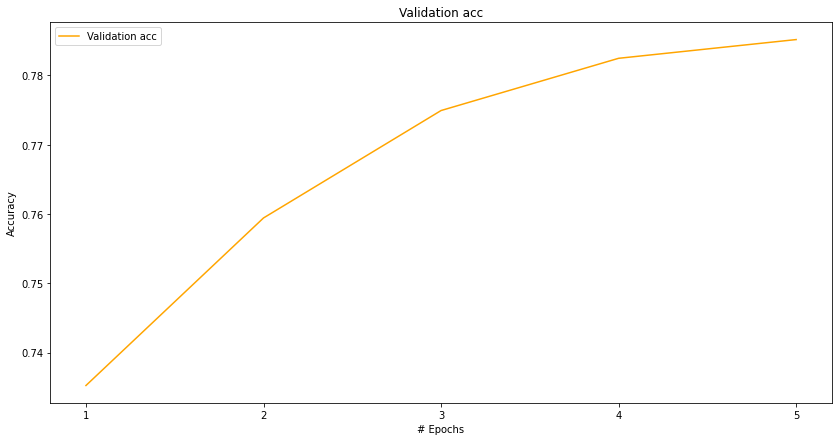

In [ ]:
plot_learning(train_loss, val_loss, val_acc, EPOCHS)

# 7. Evaluation on Training and Validation set

In [17]:
# load best model
best_model = DistillBERTClass()
best_model.load_state_dict(torch.load(MODEL_PATH))
best_model.to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [18]:
def predict_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

**TRAINING**

100%|██████████| 1026/1026 [04:12<00:00,  4.06it/s]


Training Accuracy Score = 0.966434973477227
Training F1-Score = 0.9665236599005206


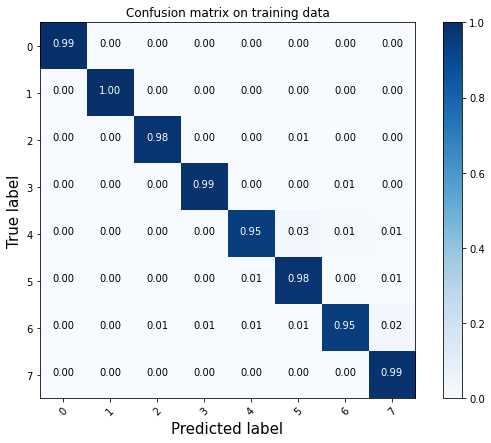

In [19]:
train_outputs, train_targets = predict_fn(
    train_data_loader,
    model=best_model,
    device=DEVICE
)

train_outputs = np.argmax(train_outputs, axis=1)

accuracy = accuracy_score(train_targets, train_outputs)
f_score = f1_score(train_targets, train_outputs, average='weighted')
print(f"Training Accuracy Score = {accuracy}")
print(f"Training F1-Score = {f_score}")

# print the confusion matrix
cnf_matrix = confusion_matrix(train_targets, train_outputs, labels=[0, 1, 2, 3, 4, 5, 6, 7])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['0','1', '2', '3', '4', '5', '6', '7'],
    normalize=True,
    title='Confusion matrix on training data'
)

Overfitting

**VALIDATION**

100%|██████████| 440/440 [00:55<00:00,  7.89it/s]


Val Accuracy Score = 0.7851556945826816
Val F1-Score = 0.7866395637628797


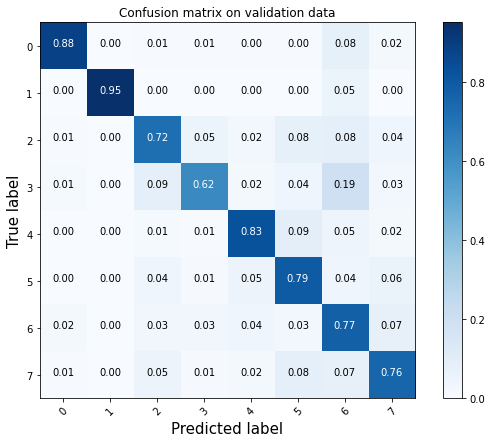

In [21]:
val_outputs, val_targets = predict_fn(
    val_data_loader,
    model=best_model,
    device=DEVICE
)

val_outputs = np.argmax(val_outputs, axis=1)

accuracy = accuracy_score(val_targets, val_outputs)
f_score = f1_score(val_targets, val_outputs, average='weighted')
print(f"Val Accuracy Score = {accuracy}")
print(f"Val F1-Score = {f_score}")

# print the confusion matrix
cnf_matrix = confusion_matrix(val_targets, val_outputs, labels=[0, 1, 2, 3, 4, 5, 6, 7])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['0','1', '2', '3', '4', '5', '6', '7'],
    normalize=True,
    title='Confusion matrix on validation data'
)

Taxonomies that the model struggles with:

encoding_dict = {2: 0, 9: 1, 59: 2, 70: 3, 173: 4, 268: 5, 273: 6, 280: 7}

- Taxonomy 9 (Class 1)
- Taxonomy 59 (Class 2)
- Taxonomy 70 (Class 3)
- Taxonomy 280 (Class 7)

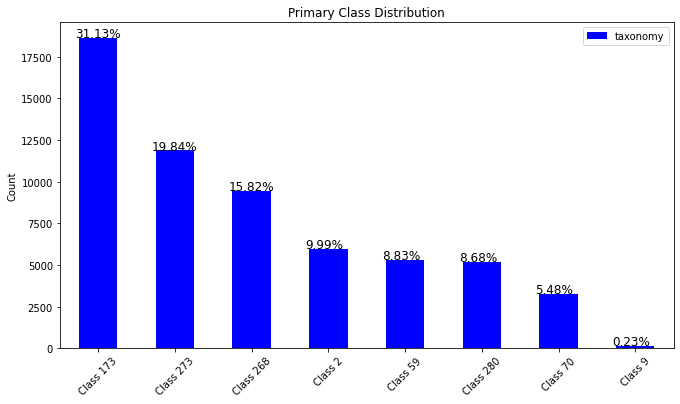